In [204]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm
import mpmath as mp
from scipy.optimize import root_scalar as root

In [2]:
#------------------------ CHANGE THIS----------------
tInt = 2.7 #s
#----------------------------------------

In [3]:
mp.mp.dps = 50
fe3 = mp.mpf('642121496772645.10')
fe2 = mp.mpf('688358979309308.22')
R_Godun = mp.mpf('0.93282940453096496') #mp.mpf('0.93282940453096465')
R_Lange = mp.mpf('0.932829404530965376')

In [4]:
B = mp.mpf(31.275/(1e-9*0.59930*9.2740100657e-24/6.626e-34)) # in mu T
e2Zee = 52.14*B**2*1e-3
e3Zee = -2.082*B**2*1e-3
e2BBR = -537e-18*fe2 #-517e-18*fe2
##Changed 9/15/25 to account for second order doppler and dc stark in quadrupole
e3BBR = -73.6e-18*fe3
e2Quad = 0.0 #0.049409
e3Quad = 0.0 #-0.049409/92.1
e2Shift = (e2Zee+e2BBR+e2Quad)
e3Shift = (e3Zee+e3BBR+e3Quad)

In [252]:
def lineFit(x,m,b):
    return m*x+b

def linePts(x, y):
    n = np.size(x)
    fitYs = np.zeros(n)
    param, paramcov = curve_fit(lineFit,x,y, maxfev=5000)
    print(param[0])
    for ii in range(n):
        fitYs[ii] = lineFit(x[ii], param[0], param[1])
    return fitYs

def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

def kktime2EpochTime(date_int, time_float):
    yy = int(str(date_int)[:2])
    mm = int(str(date_int)[2:4])
    dd = int(str(date_int)[4:6])

    # Handle 2-digit year properly (assume 2000–2099)
    year = 2000 + yy

    # Parse time
    hhmmss = f"{int(time_float):06d}.{int(round((time_float % 1) * 1000)):03d}"  # pad with zeros: 'HHMMSS.XXX'
    hh = int(hhmmss[0:2])
    mi = int(hhmmss[2:4])
    ss = int(hhmmss[4:6])
    ms = int(hhmmss[7:])  # fractional seconds in milliseconds

    # Create datetime object
    dt = datetime(year, mm, dd, hh, mi, ss, int(ms * 1e3))

    # Convert to epoch
    epoch_time = dt.timestamp()
    return epoch_time

In [6]:
def movingAvg(data, avgPts):
    if avgPts%2 == 1:
        n = np.size(data)
        avgData = np.zeros(n)
        for ii in range(avgPts//2):
            avgData[ii] = mp.fsum(data[:ii+avgPts//2+1])/np.size(data[:ii+avgPts//2+1])
            avgData[n-1-ii] = mp.fsum(data[n-ii-1-avgPts//2:])/np.size(data[n-ii-1-avgPts//2:])
        for ii in range(avgPts//2,n-avgPts//2,1):
            avgData[ii] = mp.fsum(data[ii-avgPts//2:ii+avgPts//2+1])/np.size(data[ii-avgPts//2:ii+avgPts//2+1])
        return avgData
    else: print("avgPts must be odd")

In [220]:
def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 80  #-----------cut off points while servo grabs---------------
    taoms=mat['aomfrequsmatrix'][ni:n,0]
    #print(ts[0])

    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom1=mat['aomfrequsmatrix'][ni:n,1]
    fe2aom2=mat['aomfrequsmatrix'][ni:n,2]
    fe2aom3=mat['aomfrequsmatrix'][ni:n,3]
    fe2aoms = [fe2aom1,fe2aom2,fe2aom3]
    fe3aom=mat['aomfrequsmatrix'][ni:n,4]
    rRquad1=mat['aomfrequsmatrix'][ni+1:n,6]
    rRquad2=mat['aomfrequsmatrix'][ni+1:n,7]
    rRquad3=mat['aomfrequsmatrix'][ni+1:n,8]
    rRquads = [rRquad1,rRquad2,rRquad3]
    rRoct = mat['aomfrequsmatrix'][ni+1:n,10]
    return taoms, fe2aoms, fe3aom, rRquads, rRoct

In [250]:
def importkk(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                values = line.strip().split()
                values = [np.nan if v.startswith('-') else v for v in values]
                data.append(values)

    data = np.array(data, dtype=np.float64)

    dates = np.array([int(pt) for pt in data[:,0]])
    times = data[:, 1]
    ts = np.zeros(np.size(times))
    for ii in range(np.size(times)):
        ts[ii] = kktime2EpochTime(dates[ii], times[ii])

    frep = data[:,11]
    fceo = data[:,12]
    f871 = data[:,16]
    f933 = data[:,17]
    return ts, frep, f871, f933

In [241]:
def trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct):
    ni=0
    if ts[0]>taoms[0]:
        print("case 1")
        for ii in range(np.size(taoms)):
            if (taoms[ii] - tInt)>ts[0]: 
                ni=ii
                break
        taoms = taoms[ni:]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][ni:]
            rRquads[ii] = rRquads[ii][ni+1:]
        fe3aom = fe3aom[ni:]
        rRoct = rRoct[ni+1:]
        print(ts[0]-taoms[0])
    else:
        print("case 2")
        for ii in range(np.size(ts)):
            if ts[ii]>(taoms[0]-tInt):
                ni=ii
                break
        ts = ts[ni:]
        f871s = f871s[ni:]
        f933s = f933s[ni:]
        print(ts[0]-taoms[0])
    
    if ts[-1]>taoms[-1]:
        print("case 1")
        for ii in range(np.size(ts)):
            if ts[ii]>taoms[-1]:
                nf=ii
                break
        ts = ts[:nf+1]
        f871s = f871s[:nf+1]
        f933s = f933s[:nf+1]
        print(ts[-1]-taoms[-1])
    else:
        print("case 2")
        for ii in range(np.size(taoms)):
            if taoms[ii]>ts[-1]:
                nf=ii
                break
        taoms = taoms[:nf]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][:nf]
            rRquads[ii] = rRquads[ii][:nf-1]
        fe3aom = fe3aom[:nf]
        rRoct = rRoct[:nf-1]
        print(ts[-1]-taoms[-1])
    return ts, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct

In [367]:
def calcLeftExcs(rRoct, rRquads):
    tekDeltafrequ = 13*3/4
    rLoct = np.zeros(np.size(rRoct))
    for ii in range(np.size(rRoct)-1):
        rLoct[ii] = rRoct[ii]+0.5*(fe3aom[ii+1]-fe3aom[ii])*3*30*2/tekDeltafrequ
    if np.min(rLoct)<(-0.1) or np.max(rLoct)>1.1: print("Warning!!! Excitation fraction calc error")
    rLoct = np.round(rLoct*2)/2
    
    deltafrequQuad = 15*28/40
    rLquads = [np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0]))]
    
    for ii in range(3):
        for jj in range(np.size(rRquads[0])-1):
            rLquads[ii][jj] = rRquads[ii][jj]-0.5*(fe2aoms[ii][jj+1]-fe2aoms[ii][jj])*30/deltafrequQuad
    if np.min(rLquads)<(-0.1) or np.max(rLquads)>1.1: print("Warning!!! Excitation fraction calc error")
    rLquads = np.round(rLquads*2)/2
    return rLoct, rLquads

In [290]:
def ratioCalc(data):
    ts, freps, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct, beatSign933, beatSign871 = data
    #------------rLoct, rLquads = calcLeftExcs(rRoct, rRquads)---------------
    #Average beat note data
    n = np.size(taoms)
    f871adj = np.zeros(n)
    f933adj = np.zeros(n)
    ii = 0
    n1 = 0 
    n2 = 0
    while ii<n:
        while ts[n1] < (taoms[ii]-tInt):
            n1+=1
        while ts[n2] < taoms[ii]:
            n2 +=1
        f871adj[ii] = np.average(f871s[n1:n2])
        f933adj[ii] = np.average(f933s[n1:n2])
        ii+=1
        
    for ii in range(np.size(f871adj)):
        if f871adj[ii]==None:
            print(ii)
    #Calculate comb teeth
    frep = np.average(freps)/4+245000000
    fceo = mp.mpf('70e6')
    print("------Comb Teeth------")
    print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = mp.mpf(n871)
    print(n871)
    print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = mp.mpf(n933)
    print(n933)
    print("----------------------")

    #Calculate ratio
    print(f871adj[0])
    nuA = fceo - beatSign871*f871adj
    nuB = (n871/n933)*(fceo-beatSign933*f933adj)
    nuC = nuA - nuB
    f933 = fe3/2 + np.average(fe3aom)/2 + 80e6
    ratio = nuC/f933+n871/n933
    e3Quad = -np.array([(fe2aoms[0][i] + fe2aoms[1][i] + fe2aoms[2][i]) / 3 for i in range(len(fe2aoms[0]))] - fe2aoms[0])/92.1

    e3servErr = 0.0#servoErrRam(rRoct, rLoct, np.pi/(2*26.2e-3), 26.2e-3,  32.5e-3, 150e-3)
    e2servErr1 = 0.0#servoErrRabi(rRquads[0], rLquads[0], np.pi/(40e-3), 40e-3)
    e2servErr2 = 0.0#servoErrRabi(rRquads[1], rLquads[1], np.pi/(40e-3), 40e-3)
    e2servErr3 = 0.0#servoErrRabi(rRquads[2], rLquads[2], np.pi/(40e-3), 40e-3)
    print("Octupole servo error: ", e3servErr, " Hz")
    print("Quadrupole servo error: ", (e2servErr1+e2servErr2+e2servErr3)/3, " Hz")
    
    R1 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad+e3servErr)/f933)/(2.*ratio-240e6/f933-fe2aoms[0]/f933-(e2Shift+e2servErr1)/f933)
    R2 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad+e3servErr)/f933)/(2.*ratio-240e6/f933-fe2aoms[1]/f933-(e2Shift+e2servErr2)/f933)
    R3 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad+e3servErr)/f933)/(2.*ratio-240e6/f933-fe2aoms[2]/f933-(e2Shift+e2servErr3)/f933)
    Rs = np.array([R1,R2,R3])
    return taoms, Rs

In [330]:
def psi(g,e):
    return np.array([g, e])
def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0
def rhoee(psi):
    return (abs(psi[1]))**2.0
def rhogg(psi):
    return (abs(psi[0]))**2.0
def rho(delta, Omega0, rho22, t):
    Omega = np.sqrt(Omega0**2+ delta**2)
    return 0.69*(Omega0/Omega*np.sin(Omega*t/2))**2-rho22
def rho2deltaRabi(Omega0, rho22, t):
    return root(rho, args=(Omega0,rho22, t), bracket=[0,Omega0]).root
def rhoRamsey(delta, Omega0, rho22, t1, t2, T):
    psi0 = psi(1.0, 0.0)
    return rhoee(pulse(t2, Omega0, delta, 0.0, 0.0)@pulse(T, 0.0, delta, 0.0, 0.0)@pulse(t1, Omega0, delta, 0.0, 0.0)@psi0)-rho22
def rho2deltaRamsey(Omega0, rho22, t1, t2, T):
    return root(rhoRamsey, args=(Omega0,rho22, t1, t2, T), bracket=[0.0,Omega0/3]).root

In [326]:
def servoErrRabi(rRs, rLs, Omega0, t):
    return rho2deltaRabi(Omega0, np.average(rRs), t)/(2.0*np.pi) - rho2deltaRabi(Omega0, np.average(rLs), t)/(2.0*np.pi)

def servoErrRam(rRs, rLs, Omega0, t1, t2, T):
    return rho2deltaRamsey(Omega0, np.average(rRs), t1, t2, T)/(2.0*np.pi) - rho2deltaRamsey(Omega0, np.average(rLs), t1, t2, T)/(2.0*np.pi)

In [355]:
np.average(rLquads)

np.float64(0.0689766081871345)

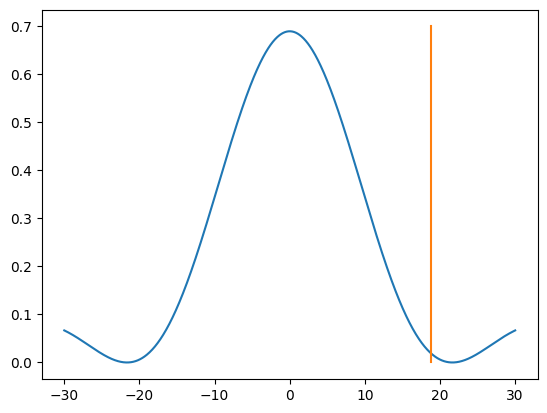

In [336]:
pts = 1000
deltas = np.linspace(-30*2*np.pi, 30*2*np.pi, pts)
rhoPts = np.zeros(pts)
for ii in range(pts):
    rhoPts[ii] = rho(deltas[ii], np.pi/40e-3, 0, 40e-3)
plt.plot(deltas/(2*np.pi), rhoPts)
plt.plot([1.5*np.pi/40e-3/(2*np.pi), 1.5*np.pi/40e-3/(2*np.pi)], [0,0.7])

In [346]:
rLquads[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [339]:
rho2deltaRabi(np.pi/(40e-3), np.average(rLquads[0]), 40e-3)/(2.0*np.pi)

ValueError: f(a) and f(b) must have different signs

In [365]:
rLoct, rLquads = calcLeftExcs(rRoct, rRquads)


Warning!!! Excitation fraction calc error


In [370]:
rRquads[0]

array([0. , 0. , 0.5, ..., 0. , 0. , 0.5])

In [342]:
rLquads[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [338]:
rho2deltaRabi(np.pi/(40e-3), np.average(rRquads[0]), 40e-3)/(2.0*np.pi)

10.942401644396458

In [368]:
taoms, fe2aoms, fe3aom, rRquads, rRoct = importMatlab(aomFile)
rLoct, rLquads = calcLeftExcs(rRoct, rRquads)
servoErrRabi(rRquads[1], rLquads[1], np.pi/(40e-3), 40e-3)

ValueError: f(a) and f(b) must have different signs

In [294]:
servoErrRam(rRoct, rLoct, np.pi/(2*26.2e-3), 26.2e-3,  32.5e-3, 150e-3)

-0.014290536176706947

In [354]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250918_1_a.mat"
kkFile = r"C:\Users\markl\Documents\Data\PhaseFreq_A_1_250730_6.txt"
data1 = files2data(kkFile, aomFile, 1, -1)
#data6a, data6b = mokuBreaker(data6)
taoms, Rs = ratioCalc(data1)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("Error: ", 1e17*(ratioVal-R_Lange)/R_Lange)

R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

Trimming.....
case 2
-4281010.341004133
case 2


IndexError: index -1 is out of bounds for axis 0 with size 0

In [304]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250917_1_b.mat"
kkFile = r"C:\Users\markl\Documents\Data\PhaseFreq_A_1_250917_2.txt"
data1 = files2data(kkFile, aomFile, 1, -1)
#data6a, data6b = mokuBreaker(data6)
taoms, Rs = ratioCalc(data1)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("Error: ", 1e17*(ratioVal-R_Lange)/R_Lange)

R = []
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

Trimming.....
case 2
-2.00199556350708
case 2
0.20799660682678223
Done.
Start time:  2025-09-17 11:27:34.001996
End time:  2025-09-17 16:11:47.792003
5689  data points
------Comb Teeth------
1376720.9999997683005887869077521350869553469223759
1376721.0
1284245.999999784778367225830254136282701180715122
1284246.0
----------------------
21575602.549826782
Octupole servo error:  0.0  Hz
Quadrupole servo error:  0.0  Hz
Error:  -6.7753628998886543364368800121679576220383938138719


mpf('-6.7753628998886543364368800121679576220383938138718871')

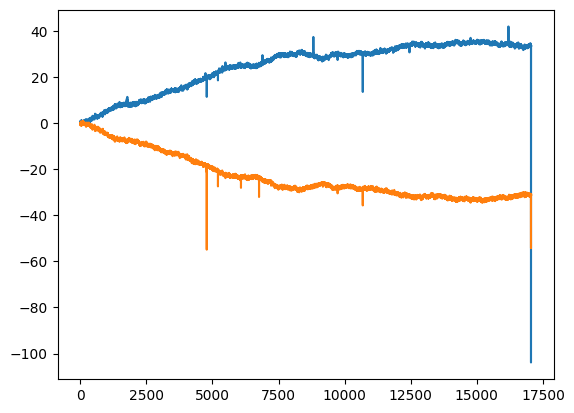

In [303]:
ts, freps, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct, beatSign933, beatSign871 = data1
plt.plot(ts-ts[0], f871s[:17500]-f871s[0])
plt.plot(ts-ts[0], f933s[:17500]-f933s[0])


mpf('-12.36201736229667068133887647811958968075086114663882')

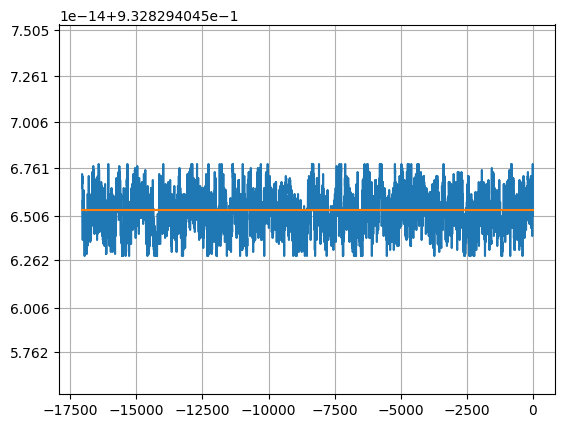

In [300]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
R = remOuts(R, lim/4)
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
#plt.plot([tShutter-taoms[-1], tShutter-taoms[-1]], [float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

In [262]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250916_1_a.mat"
kkFile = r"C:\Users\markl\Documents\Data\PhaseFreq_A_1_250916_2.txt"
ts, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct, beatSign933, beatSign871 =  files2data(kkFile, aomFile, 1, 1)
rLoct, rLquads = calcLeftExcs(rRoct, rRquads)
servoErrRabi(rRquads[0], rLquads[0], np.pi/(40e-3), 40e-3)

Trimming.....
case 2
-2.2500030994415283
case 1
0.9750032424926758
Done.
Start time:  2025-09-16 09:30:48.250003
End time:  2025-09-16 16:48:36.024997
8808  data points


0.0

In [289]:
def files2data(kkFile, aomFile, beatSign933, beatSign871):
    ts, freps, f871s, f933s  = importkk(kkFile)
    taoms, fe2aoms, fe3aom, rRquads, rRoct  = importMatlab(aomFile)
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    print(np.size(taoms), " data points")
    return ts, freps, f933s, f871s, taoms, fe2aoms, fe3aom, rRquads, rRoct, beatSign933, beatSign871

In [32]:
def remOuts(R, lim):
    for ii in range(np.size(R)):
        if (R_Lange-lim)>R[ii]: R[ii] = R_Lange-lim
        elif R[ii]>(R_Lange+lim): R[ii] = R_Lange+lim
    return R

In [263]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250916_1_a.mat"
kkFile = r"C:\Users\markl\Documents\Data\PhaseFreq_A_1_250916_2.txt"
data1 = files2data(kkFile, aomFile, 1, -1)
#data6a, data6b = mokuBreaker(data6)
taoms, Rs = ratioCalc(data1)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("Error: ", 1e17*(ratioVal-R_Lange)/R_Lange)

R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

Trimming.....
case 2
-2.2500030994415283
case 1
0.9750032424926758
Done.
Start time:  2025-09-16 09:30:48.250003
End time:  2025-09-16 16:48:36.024997
8808  data points
------Comb Teeth------
1376719.9999983359902130996268080134197670057874755
1376720.0
1284244.9999984486618227130534092687200635953547685
1284245.0
----------------------
24239543.216228843
Octupole servo error:  0.0  Hz
Quadrupole servo error:  0.0  Hz
Error:  -7.0834047804757405825842079474245877121411125135845


mpf('-7.0834047804757405825842079474245878554022863739907021')

mpf('-7.2454895355281349517518327741107552183474124775606163')

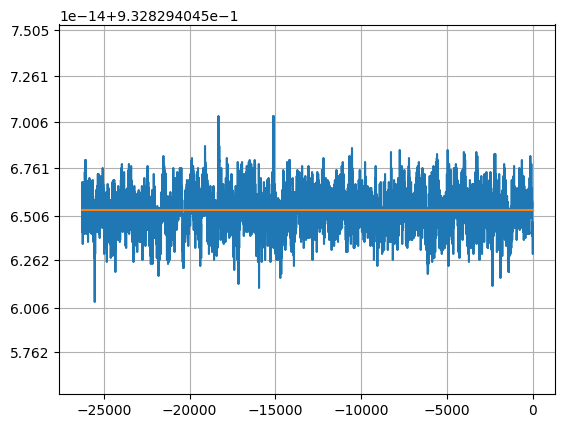

In [285]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
R = remOuts(R, lim/2)
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
#plt.plot([tShutter-taoms[-1], tShutter-taoms[-1]], [float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

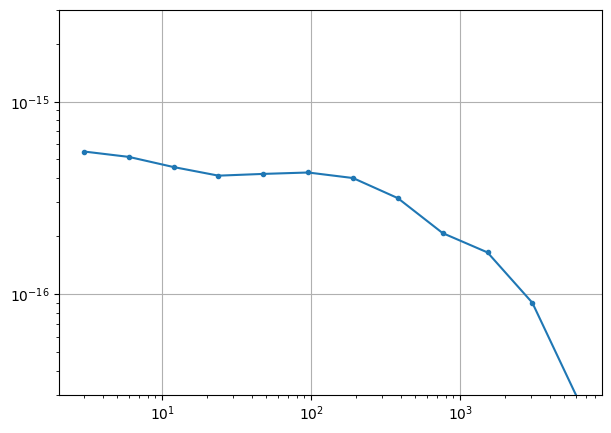

In [286]:
rate=1./np.mean(np.diff(taoms))
floatRs = np.zeros(np.size(R))
for ii in range(np.size(R)):
    floatRs[ii] = float(R[ii])
taus, adev, adevErr,_ = al.mdev(floatRs, rate, data_type="freq")
plt.figure(figsize=(7,5), dpi=100)
plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, c="tab:blue")
plt.ylim([3e-17, 3e-15])
plt.grid()

In [238]:
aomFile = r"C:\Users\markl\Documents\Data\aomfrequs-20250915_1.mat"
kkFile = r"C:\Users\markl\Documents\Data\PhaseFreq_A_1_250915_1.txt"
data1 = files2data(kkFile, aomFile, 1, -1)
#data6a, data6b = mokuBreaker(data6)
taoms, Rs = ratioCalc(data1)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("Error: ", 1e17*(ratioVal-R_Lange)/R_Lange)

R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

Trimming.....
case 1
-3.3899993896484375
case 1
0.624997615814209
Done.
Start time:  2025-09-15 15:47:34.389999
End time:  2025-09-15 18:20:37.375002
3085  data points
------Comb Teeth------
1376719.9999997065358981916521324580026137136090747
1376720.0
1284244.9999997272353117737576214267971109261288085
1284245.0
----------------------
24239289.188869465
Octupole servo error:  0.0  Hz
Quadrupole servo error:  0.0  Hz
Error:  -13.760956004105799435329527386613301237731496645845


mpf('-13.760956004105799435329527386613301237731496645844746')

mpf('-20.055488174316064212246565394338316151003174107248682')

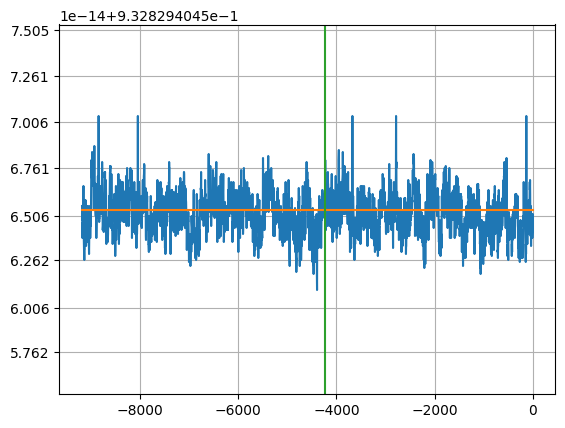

In [47]:
tShutter = datetime(2025, 9, 15, 17, 10, 00).timestamp()
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
R = remOuts(R, lim/2)
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.plot([tShutter-taoms[-1], tShutter-taoms[-1]], [float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
1e17*((mp.fsum(R)/np.size(R)-R_Lange)/R_Lange)

In [55]:
ts,freps,f871s, f933s = importkk(kkFile)

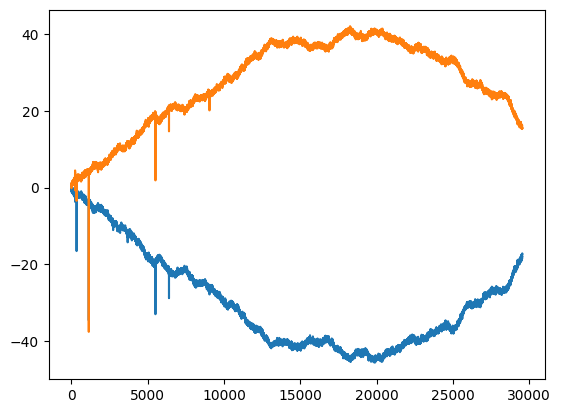

In [56]:
plt.plot(ts-ts[0], f871s-f871s[0])
plt.plot(ts-ts[0], f933s-f933s[0])

In [52]:
nCut = np.argmin(np.abs(taoms-tShutter))
1e17*((mp.fsum(R[:nCut])/np.size(R[:nCut])-R_Lange)/R_Lange)

mpf('-13.751963510627132002491120985838932330972622784543544')

In [53]:
1e17*((mp.fsum(R[nCut:])/np.size(R[nCut:])-R_Lange)/R_Lange)

mpf('-27.403698105301757659012041319976642836186653131642137')

In [60]:
np.size(R[:nCut])

1660

In [59]:
np.size(R[nCut:])

1424

In [228]:
fe3/fe2-R_Lange

mpf('-4.0485328485559657833730743754327753333637030154196459e-18')